In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib/")
sys.path.append("C:/dev/pycmqlib/scripts/")

import misc
import data_handler as dh
import plotly_examples
import backtest
%matplotlib inline

In [2]:
start = datetime.date(2016, 1, 1)
end = datetime.date(2020, 3, 20)
shift_mode = 1
asset = 'rb'
freq = 'm'
args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'shift_mode': shift_mode}
args['start_date'] = start
args['end_date'] = end
mdf = misc.nearby(asset, **args)
mdf = misc.cleanup_mindata(mdf, asset)
print mdf[-5:]


                     instID  exch        date  min_id  open  high   low  \
datetime                                                                  
2020-03-20 14:55:00  rb2005  SHFE  2020-03-20    2055  3491  3492  3489   
2020-03-20 14:56:00  rb2005  SHFE  2020-03-20    2056  3490  3491  3481   
2020-03-20 14:57:00  rb2005  SHFE  2020-03-20    2057  3482  3486  3481   
2020-03-20 14:58:00  rb2005  SHFE  2020-03-20    2058  3482  3489  3479   
2020-03-20 14:59:00  rb2005  SHFE  2020-03-20    2059  3487  3489  3482   

                     close   volume  openInterest contract  shift  
datetime                                                           
2020-03-20 14:55:00   3490   3796.0      902853.0   rb2005    0.0  
2020-03-20 14:56:00   3481   7975.0      900581.0   rb2005    0.0  
2020-03-20 14:57:00   3481   7577.0      898670.0   rb2005    0.0  
2020-03-20 14:58:00   3488  11251.0      894258.0   rb2005    0.0  
2020-03-20 14:59:00   3485  12628.0      890657.0   rb2005    0.0 

C:\dev\anaconda2\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [7]:
price_mode = 'CL'
ref_mode = 'xopen'
atr_win = 10

xdf = dh.conv_ohlc_freq1(mdf, '60m')
#df = mdf.copy()
#df = dh.day_split1(mdf, [300, 1500, 1930, 2100])

xdf['ATR'] = dh.ATR(xdf, atr_win).shift(1)
xdf['xma'] = dh.MA(xdf, atr_win).shift(1)
xdf['xclose'] = xdf['close'].shift(1)
xdf['xopen'] = xdf['open']

df = mdf.join(xdf[['ATR', 'xclose', 'xopen', 'xma']], how='left').fillna(method='ffill').dropna()

#fig2 = plotly_examples.plot_ohlc_with_indicators(df, ind_fields = ['MA1', 'MA2', 'MA3'])
#fig2.layout.on_change(zoom, 'xaxis.range')
#fig2

C:\dev\anaconda2\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



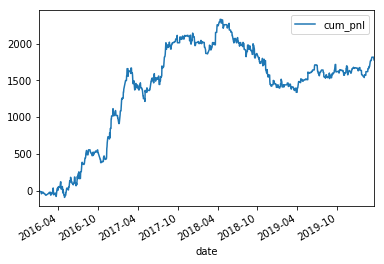

{'trade_std': 41.17436197860324, 'win_ratio': 0.5207667731629393, 'win_std': 32.630318388732775, 'loss_25pct': -39.0, 'loss_75pct': -8.0, 'loss_mean': -26.606666666666666, 'trade_50pct': 2.0, 'win_50pct': 25.0, 'trade_max': 170.0, 'loss_sum': -7982.0, 'trade_75pct': 26.0, 'win_75pct': 48.75, 'win_max': 170.0, 'win_min': 1.0, 'win_sum': 11009.0, 'trade_sum': 3027.0, 'trade_count': 626.0, 'trade_min': -113.0, 'win_count': 326.0, 'trade_25pct': -21.0, 'win_25pct': 9.25, 'trade_mean': 4.835463258785943, 'win_mean': 33.76993865030675, 'loss_50pct': -24.0, 'loss_max': -0.0, 'loss_std': 21.947763057610203, 'loss_min': -113.0, 'loss_count': 300.0}
                              0
avg_pnl_1y             1.612245
avg_pnl_2y            -0.485656
avg_pnl_3y             0.551160
avg_pnl_4y             1.849385
max_dd_period_1y     -62.000000
max_dd_period_2y    -349.000000
max_dd_period_3y    -349.000000
max_dd_period_4y    -349.000000
max_drawdown_1y     -186.000000
max_drawdown_2y     -989.000000


In [8]:
tick_base = 1.0
pnl_tenors = ['1y', '2y', '3y', '4y']
cost_ratio = 1.0
offset = 1.0
start_capital = 0.0
band_ratio = 1.5

close_daily = True
exit_min = 2057
tcost = 0.0
margin_rate = [0.08, 0.08]

if price_mode == "HL":
    up_price = df['high']
    dn_price = df['low']
elif price_mode == "TP":
    up_price = (df['high'] + df['low'] + df['close'])/3.0
    dn_price = up_price
elif price_mode == "CL":
    up_price = df['close']
    dn_price = df['close']
else:
    print "unsupported price mode"
df['upper'] = df[ref_mode] + df['ATR'] * band_ratio
df['upper'] = (df['upper']/tick_base).astype('int') * tick_base
df['lower'] = df[ref_mode] - df['ATR'] * band_ratio
df['lower'] = (df['lower'] / tick_base).astype('int') * tick_base
df['pos']  = np.nan
df['traded_price'] = df['open']
df.loc[dh.CROSSOVER2(up_price, df['upper'], value = 0, direction = 1), 'pos'] = 1.0
df.loc[dh.CROSSOVER2(dn_price, df['lower'], value = 0, direction = -1), 'pos'] = -1.0
if close_daily:
    df.loc[df['min_id'] >= exit_min, 'pos'] = 0
df['pos'][-2:] = 0
df['pos'] = df['pos'].shift(1).fillna(method='ffill')
df['pos'] = df['pos'].fillna(0)
df['cost'] = abs(df['pos'] - df['pos'].shift(1)) * (offset + df['open'] * tcost)
df['cost'] = df['cost'].fillna(0.0)
closed_trades = backtest.simdf_to_trades1(df, slippage = offset)
res_trade = backtest.get_trade_stats(closed_trades)
(res_pnl, ts) = backtest.get_pnl_stats([df], margin_rate, 'm', tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
ts[['cum_pnl']].plot()
plt.show()
print res_trade
pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
print pnl_df